# DSTL Image Dataset Exploration

Dataset provided via the Kaggle competition [DSTL Satellite Imagery Feature Detection](https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/data?select=train_geojson_v3.zip). Dataset consists of 450 satellite images, provided as 3-band (RGB) and 16-band (PAM only) TIFF images.

Features to be detected in the images are given by `CLASSES` below. A single image may have multiple features identified by polygons on the image. Only 25 images are annotated with polygons representing these features.

Our objective is to derive a dataset from these 25 images of size (224, 224, 3) where each patch of the image represents a single class.

In [1]:
import geojson
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
import re

from rasterio.plot import show, reshape_as_image
from matplotlib import pyplot

%matplotlib inline

In [2]:
DATA_DIR = "data"

IMAGE3_DIR = os.path.join(DATA_DIR, "three_band")
IMAGE16_DIR = os.path.join(DATA_DIR, "sixteen_band")

GEOJSON_DIR = os.path.join(DATA_DIR, "train_geojson_v3")

WKT_FILE = os.path.join(DATA_DIR, "train_wkt_v4.csv")

GRID_SIZES = os.path.join(DATA_DIR, "grid_sizes.csv")

CLASSES = {
    1: "Buildings",
    2: "Man-made structures",
    3: "Road",
    4: "Track",
    5: "Woodland",
    6: "Crops",
    7: "Waterway",
    8: "Standing water",
    9: "Vehicle large",
    10: "Vehicle small"
}

PATCH_WIDTH, PATCH_HEIGHT = 224, 224

OUTPUT_DIR = os.path.join(DATA_DIR, "output_images")

## Images

There are 450 TIFF files in the `three_band` folder and there are 1350 TIFF files, corresponding to the A, P, and M bands of the 450 satellite images in the `sixteen_band` folder. The 450 TIFF files in the `three_band` folder contain the R, G, B channels whereas the TIFF files in the `sixteen_band` folder are single channel.

In [3]:
images3 = os.listdir(IMAGE3_DIR)
images16 = os.listdir(IMAGE16_DIR)

print(len(images3), len(images16))

450 1350


## 3-band images

Image colors look unnatural because TIF files don't report color, they report reflectance along different channels and are outside the pixel intensity range 0..255. These images are normalized to rescale each pixel by the `255 / max(image)`.

NOTE: more natural images are possible if we take the 1st channel from the M file, but these result in channel depth 1

In [4]:
image_files = [image_file for image_file in os.listdir(IMAGE3_DIR)]
len(image_files)

450

In [5]:
sample_images = np.random.randint(0, len(image_files), 5)

/Users/palsujit/anaconda3/envs/hf-flax/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


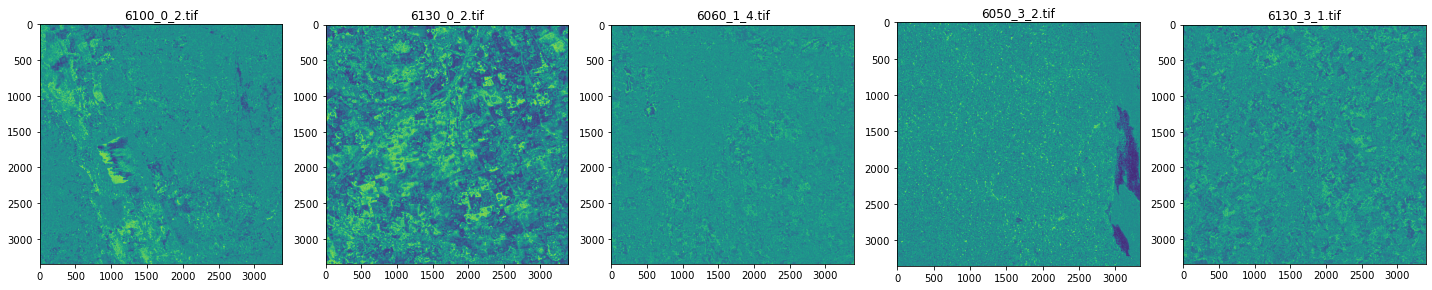

In [6]:
def normalize_image_int32(image):
    smax=255
    image = image * np.max(image) / smax
    return image.astype(np.uint8)

# def normalize_image_int32(image):
#     smax=255
#     image_min, image_max = np.min(image), np.max(image)
#     image = (image - image_min) / (image_max - image_min)
#     image = image * image_max / smax
#     return image.astype(np.uint8)


def read_image(image_file_path):
    image = None
    with rasterio.open(image_file_path) as src:
        raster = src.read()
        image = reshape_as_image(raster)
        norm_image = normalize_image_int32(image)
    return norm_image


plt.figure(figsize=(20, 30))
for i in range(len(sample_images)):
    plt.subplot(1, 5, i+1)
    image_file_name = image_files[sample_images[i]]
    image = read_image(os.path.join(IMAGE3_DIR, image_file_name))
    plt.imshow(image[:, :, 0])
    plt.title(image_file_name)

plt.tight_layout()
plt.show()

## 16-band images

Produced out of the P, A, M channels from the 16 channels, treated as R, G, B layers. See [How to make a true-color LANDSAT 8 Image](https://earthobservatory.nasa.gov/blogs/elegantfigures/2013/10/22/how-to-make-a-true-color-landsat-8-image/) for some information on this. Produces better images IMO than the 3-band images.

In [7]:
[image_files[i] for i in sample_images]

['6100_0_2.tif',
 '6130_0_2.tif',
 '6060_1_4.tif',
 '6050_3_2.tif',
 '6130_3_1.tif']

In [8]:
x = np.random.random((224, 224, 1))
xx = np.concatenate([x, x, x], axis=2)
x.shape, xx.shape

((224, 224, 1), (224, 224, 3))

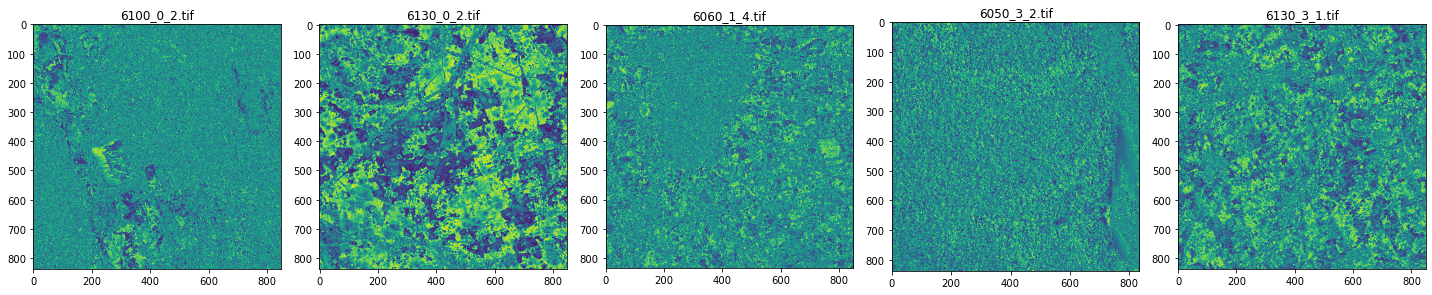

In [9]:
def read_image16(img_file_path):
    img16_file_path = img_file_path.replace(".tif", "_M.tif")
    with rasterio.open(img16_file_path) as src:
        b, g, r = src.read(2), src.read(3), src.read(4)
    image = np.stack([r, g, b], axis=2)
    norm_image = normalize_image_int32(image)
    return norm_image


plt.figure(figsize=(20, 30))
for i in range(len(sample_images)):
    plt.subplot(1, 5, i+1)
    image_file_name = image_files[sample_images[i]]
    image = read_image16(os.path.join(IMAGE16_DIR, image_file_name))
    plt.imshow(image[:, :, 0])
    plt.title(image_file_name)

plt.tight_layout()
plt.show()

## Labels

We will use the `geojson` labels because it is easier to parse the polygons out, even though overall the JSON labels are more complex to parse compared to the WKT version.

In [10]:
filename_to_classtype = {
    '001_MM_L2_LARGE_BUILDING':1,
    '001_MM_L3_RESIDENTIAL_BUILDING':1,
    '001_MM_L3_NON_RESIDENTIAL_BUILDING':1,
    '001_MM_L5_MISC_SMALL_STRUCTURE':2,
    '002_TR_L3_GOOD_ROADS':3,
    '002_TR_L4_POOR_DIRT_CART_TRACK':4,
    '002_TR_L6_FOOTPATH_TRAIL':4,
    '006_VEG_L2_WOODLAND':5,
    '006_VEG_L3_HEDGEROWS':5,
    '006_VEG_L5_GROUP_TREES':5,
    '006_VEG_L5_STANDALONE_TREES':5,
    '007_AGR_L2_CONTOUR_PLOUGHING_CROPLAND':6,
    '007_AGR_L6_ROW_CROP':6, 
    '008_WTR_L3_WATERWAY':7,
    '008_WTR_L2_STANDING_WATER':8,
    '003_VH_L4_LARGE_VEHICLE':9,
    '003_VH_L5_SMALL_VEHICLE':10,
    '003_VH_L6_MOTORBIKE':10
}

In [11]:
labeled_image_ids = [lid for lid in os.listdir(GEOJSON_DIR) if not lid.startswith(".")]
print(len(labeled_image_ids))

25


In [12]:
image_to_coord_label = {}
for labeled_image_id in labeled_image_ids:
    for json_file in os.listdir(os.path.join(GEOJSON_DIR, labeled_image_id)):
        try:
            class_type = filename_to_classtype[json_file.split('.')[0]]
        except KeyError:
            # label that doesnt correspond to our classes
            continue
        with open(os.path.join(GEOJSON_DIR, labeled_image_id, json_file), "r") as fjson:
            data = geojson.loads(fjson.read())
            polygon_coords = data["features"][0]["geometry"]["coordinates"]
            if labeled_image_id in image_to_coord_label.keys():
                image_to_coord_label[labeled_image_id].append((class_type, polygon_coords))
            else:
                image_to_coord_label[labeled_image_id]= [(class_type, polygon_coords)]

len(image_to_coord_label)

25

In [13]:
image_to_coord_label[labeled_image_ids[0]]

[(2,
  [[[0.007833, -0.000674],
    [0.007826, -0.000669],
    [0.00782, -0.000656],
    [0.007821, -0.000642],
    [0.007831, -0.000636],
    [0.007846, -0.000637],
    [0.007857, -0.000639],
    [0.007857, -0.000649],
    [0.007855, -0.000658],
    [0.007851, -0.000667],
    [0.007843, -0.00067],
    [0.007833, -0.000674]]]),
 (4,
  [[[0.000714, -0.004699],
    [0.00073, -0.004711],
    [0.000753, -0.004713],
    [0.000781, -0.004705],
    [0.000816, -0.004689],
    [0.000842, -0.004666],
    [0.000878, -0.004638],
    [0.000924, -0.004621],
    [0.00097, -0.004612],
    [0.001027, -0.004598],
    [0.00108, -0.004594],
    [0.001122, -0.004587],
    [0.001201, -0.004586],
    [0.001277, -0.004586],
    [0.001317, -0.00459],
    [0.001359, -0.004596],
    [0.001392, -0.004598],
    [0.001431, -0.004607],
    [0.001482, -0.004611],
    [0.00152, -0.004618],
    [0.001563, -0.00462],
    [0.001612, -0.004625],
    [0.001661, -0.004627],
    [0.001736, -0.004633],
    [0.001776, -0.00463

## Patch Construction and Detection

For each of the 25 images we have one or more polygons defined around entities of certain classes. Since we want to extract patches for classification purposes, we will take the centroid of each polygon and draw a box of size (224, 224) around it.

Note that the polygon coordinates are based on a (1, 1) image, where x=0..1 and y=-1..0. Since our numbering system is from the top corner, our y scaling will be 0..1 same as x scaling.


We will take one single image and see what we can do with it.

In [14]:
image_grid_sizes = {}
with open(GRID_SIZES, "r") as fgrid:
    for line in fgrid:
        if line.startswith(","):
            continue
        image_id, xmax, ymin = line.strip().split(',')
        image_grid_sizes[image_id] = (float(xmax), -float(ymin))
        
len(image_grid_sizes)

450

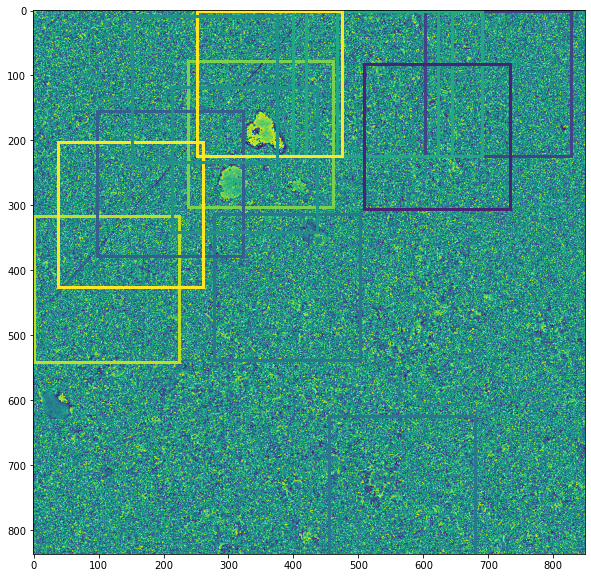

In [15]:
def get_polygon_centroids(coords, x_scale, y_scale):
    centroids = []
    for coord in coords:
        xs = [x for x, y in coord]
        ys = [y for x, y in coord]
        xc = np.mean(xs)
        yc = np.mean(ys)
        centroids.append((xc * x_scale, yc * y_scale))
    return centroids


def get_rectangle_color(label):
    cmap = plt.cm.viridis
    return cmap(float(label) / float(10))


def get_rectangle_params(centroid, image_size, patch_size):
    img_width, img_height = image_size
    patch_width, patch_height = patch_size
    xc, yc = centroid
    if xc - patch_width / 2 < 0:
        xc = patch_width // 2
    if xc + patch_width / 2 > img_width:
        xc = img_width - patch_width // 2
    if yc - patch_height // 2 < 0:
        yc = patch_height // 2
    if yc + patch_height / 2 > img_height:
        yc = img_height - patch_height // 2
    anchor = (int(xc - patch_width / 2), int(yc - patch_height / 2))
    return anchor, patch_width, patch_height


fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

image_id = labeled_image_ids[0]
full_image = read_image16(os.path.join(IMAGE16_DIR, image_id + ".tif"))
ax.imshow(full_image[:, :, 0])

x_scale = full_image.shape[0] / image_grid_sizes[image_id][0]
y_scale = full_image.shape[1] / image_grid_sizes[image_id][1]
for label, coords in image_to_coord_label[image_id]:
    for centroid in get_polygon_centroids(coords, x_scale, -y_scale):
        r_anchor, r_width, r_height = get_rectangle_params(
            centroid, full_image.shape[0:2], (PATCH_WIDTH, PATCH_HEIGHT))
        r_color = get_rectangle_color(label)
        rect = patches.Rectangle(r_anchor, r_width, r_height, 
                                 linewidth=3, facecolor="none",
                                 edgecolor=r_color)
        ax.add_patch(rect)

plt.show()

## Labeled Patches

Here we take the individual patches we discovered above and write them out into their own (224, 224, 3) images suitable for use for zero shot classification by CLIP.

In [16]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [17]:
def crop_image(centroid, image):
    anchor, width, height = get_rectangle_params(
        centroid, image.shape[0:2], (PATCH_WIDTH, PATCH_HEIGHT))
    return image[anchor[0] : anchor[0] + width, 
                 anchor[1] : anchor[1] + height, :]


flabels = open(os.path.join(OUTPUT_DIR, "labels.tsv"), "w")

num_patches = 0
for labeled_image_id in labeled_image_ids:
    image = read_image16(os.path.join(IMAGE16_DIR, labeled_image_id + ".tif"))
    x_scale = image.shape[0] / image_grid_sizes[image_id][0]
    y_scale = image.shape[1] / image_grid_sizes[image_id][1]
    patch_id = 1
    for label, coords in image_to_coord_label[labeled_image_id]:
        for centroid in get_polygon_centroids(coords, x_scale, -y_scale):
            patch_image = crop_image(centroid, image)
            patch_file = os.path.join(
                OUTPUT_DIR, "{:s}-{:d}.png".format(labeled_image_id, patch_id))
            plt.imsave(patch_file, patch_image)
            flabels.write("{:s}-{:d}.png\t{:d}\n".format(labeled_image_id, patch_id, label))
            patch_id += 1
    num_patches += patch_id
    print("Created {:3d} patches from {:s}".format(patch_id, labeled_image_id))

print("---")
print("Number of patches created: {:d}".format(num_patches))
flabels.close()

Created  15 patches from 6110_4_0
Created  13 patches from 6070_2_3
Created   6 patches from 6010_1_2
Created   5 patches from 6040_1_0
Created  10 patches from 6060_2_3
Created  14 patches from 6100_2_3
Created  16 patches from 6100_2_2
Created   8 patches from 6170_2_4
Created   8 patches from 6090_2_0
Created  14 patches from 6110_3_1
Created   4 patches from 6170_4_1
Created  14 patches from 6110_1_2
Created  16 patches from 6100_1_3
Created  12 patches from 6120_2_0
Created   6 patches from 6040_4_4
Created   8 patches from 6150_2_3
Created   5 patches from 6040_1_3
Created   5 patches from 6010_4_2
Created   7 patches from 6170_0_4
Created   3 patches from 6010_4_4
Created   7 patches from 6160_2_1
Created  15 patches from 6140_3_1
Created  14 patches from 6140_1_2
Created   4 patches from 6040_2_2
Created  15 patches from 6120_2_2
---
Number of patches created: 244


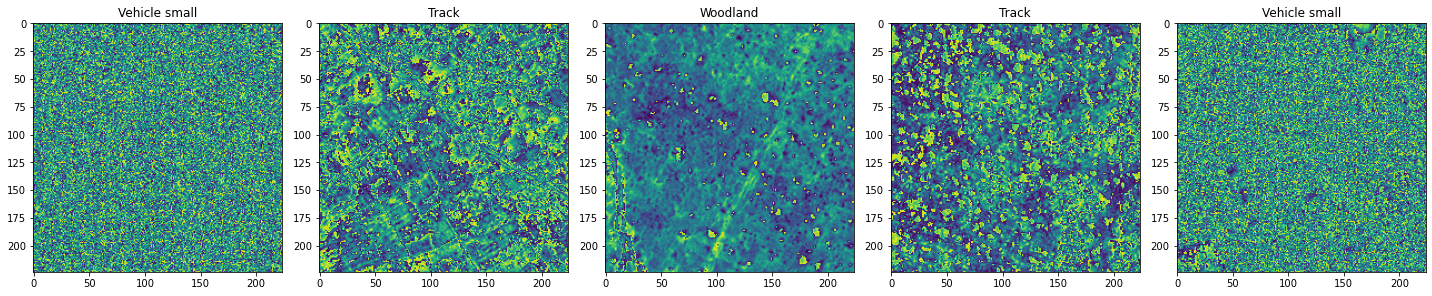

In [18]:
output_patches = os.listdir(OUTPUT_DIR)

sample_indexes = np.random.randint(0, len(output_patches), 5)
sample_patches = [output_patches[i] for i in sample_indexes]

filename_to_label = {}
with open(os.path.join(OUTPUT_DIR, "labels.tsv"), "r") as flab:
    for line in flab:
        filename, label = line.strip().split('\t')
        filename_to_label[filename] = label

plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    patch_filename = sample_patches[i]
    image = plt.imread(os.path.join(OUTPUT_DIR, patch_filename))
    label = filename_to_label[patch_filename]
    # single channel seems better
    plt.imshow(image[:, :, 0])
    plt.title(CLASSES[int(label)])
    
plt.tight_layout()
plt.show()